
# MSCI World Equity Index Inclusion Analysis

This notebook analyzes the impact of stock returns following their inclusion in the MSCI World Equity Index.

Uses cached Polygon prices (from `data_collection.ipynb`) to compute factor-purged pre-announcement CARs.


In [225]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
from pathlib import Path


In [226]:

# Load Fama-French 5 Factors (daily)
FF5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')
FF5['Date'] = pd.to_datetime(FF5['Date'], format="%Y%m%d")
FF5 = FF5.set_index('Date').dropna()
FF5 /= 100
FF5.head()


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0016,0.0001
1963-07-02,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0001
1963-07-03,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0001
1963-07-05,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0001
1963-07-08,-0.0063,0.0004,-0.0018,-0.0029,0.0014,0.0001


In [227]:

# Load MSCI additions (announcement/effective dates)
adds_MSCI = pd.read_csv('msci_additions.csv')
adds_MSCI['Announcement Date'] = pd.to_datetime(adds_MSCI['Announcement Date'])
adds_MSCI['Effective Date'] = pd.to_datetime(adds_MSCI['Effective Date'])
adds_MSCI.head()


,Ticker,Company Name,Announcement Date,Effective Date
0,NBIS,Nebius Group,2025-11-05,2025-11-25
1,CWV,CoreWeave (Private/New),2025-11-05,2025-11-25
2,INSM,Insmed,2025-11-05,2025-11-25
3,RKLB,Rocket Lab,2025-08-07,2025-08-26
4,SOFI,SoFi Technologies,2025-08-07,2025-08-26



### Load cached prices (from data_collection.ipynb)


In [228]:

prices_path = Path('polygon_prices.parquet')
if prices_path.exists():
    polygon_prices = pd.read_parquet(prices_path)
    print(f"Loaded polygon_prices from {prices_path} (rows={len(polygon_prices)})")
else:
    raise FileNotFoundError("polygon_prices.parquet not found. Run data_collection.ipynb first.")

polygon_prices.head()


Loaded polygon_prices from polygon_prices.parquet (rows=5658)


Volume       vw   Open  Close   High    Low  \
Ticker Date                                                                   
NBIS   2024-11-05 05:00:00  12434671.0  19.9152  20.74  19.00  21.20  18.51   
       2024-11-06 05:00:00   4144060.0  18.9280  19.93  19.30  19.93  17.50   
       2024-11-07 05:00:00   2570089.0  20.2407  19.08  20.68  20.90  19.08   
       2024-11-08 05:00:00   2356030.0  20.0703  20.98  19.92  21.00  19.50   
       2024-11-11 05:00:00   2907456.0  20.4884  19.80  20.94  21.30  19.18   

                                        t      n    Return  
Ticker Date                                                 
NBIS   2024-11-05 05:00:00  1730782800000  45237       NaN  
       2024-11-06 05:00:00  1730869200000  21276  0.015789  
       2024-11-07 05:00:00  1730955600000  17017  0.071503  
       2024-11-08 05:00:00  1731042000000  15403 -0.036750  
       2024-11-11 05:00:00  1731301200000  23707  0.051205


## Analysis (factor-purged CARs)
Factor-purged pre-announcement CARs using cached Polygon returns.



### Setup: returns + factors
Join Polygon returns to FF5, compute excess returns, set windows and entry days.


In [229]:

# Prepare returns merged with FF5
returns = (
    polygon_prices[['Return']]
    .dropna()
    .reset_index()
    .assign(Date=lambda df: pd.to_datetime(df['Date']).dt.tz_localize(None).dt.normalize())
)

ff5_norm = FF5.copy()
ff5_norm.index = pd.to_datetime(ff5_norm.index).tz_localize(None).normalize()

returns = (
    returns
    .merge(ff5_norm, left_on='Date', right_index=True, how='inner')
    .set_index(['Ticker', 'Date'])
    .sort_index()
)

returns['Excess'] = returns['Return'] - returns['RF']

factor_cols = [c for c in FF5.columns if c != 'RF']
est_window = (-250, -130)
entry_days = range(-120, 0)


In [230]:
returns.head()

Return  Mkt-RF     SMB     HML     RMW     CMA   RF  \
Ticker Date                                                                
ABNB   2020-12-11 -0.037731 -0.0018 -0.0057 -0.0073 -0.0058 -0.0056  0.0   
       2020-12-14 -0.066427 -0.0026  0.0021 -0.0151 -0.0039 -0.0083  0.0   
       2020-12-15 -0.040000  0.0129  0.0114  0.0038  0.0045  0.0054  0.0   
       2020-12-16  0.105689  0.0016 -0.0056 -0.0039  0.0003 -0.0017  0.0   
       2020-12-17  0.065657  0.0078  0.0050 -0.0070 -0.0058 -0.0019  0.0   

                     Excess  
Ticker Date                  
ABNB   2020-12-11 -0.037731  
       2020-12-14 -0.066427  
       2020-12-15 -0.040000  
       2020-12-16  0.105689  
       2020-12-17  0.065657


### Fit FF5 and compute abnormal returns
For each ticker, fit FF5 on the estimation window, derive ARs, and accumulate CARs for entry days.


In [231]:

# Fit per-ticker FF5 model and abnormal returns
car_by_k = {k: [] for k in entry_days}

for _, row in adds_MSCI.iterrows():
    tkr = row['Ticker']
    ann = row['Announcement Date']
    if tkr not in returns.index.get_level_values('Ticker'):
        continue

    sub = returns.xs(tkr, level='Ticker').sort_index()
    rel = pd.Series(range(len(sub)), index=sub.index) - sub.index.searchsorted(ann)
    sub['rel'] = sub.index.map(rel)

    est = sub[(sub['rel'] >= est_window[0]) & (sub['rel'] <= est_window[1])].dropna(subset=['Excess'])

    # Require full estimation window coverage
    if len(est) < (est_window[1] - est_window[0]) or est[factor_cols].isnull().any().any():
        continue

    model = sm.OLS(est['Excess'], sm.add_constant(est[factor_cols])).fit()
    sub = sub.dropna(subset=factor_cols + ['Excess'])
    sub['AR'] = sub['Excess'] - model.predict(sm.add_constant(sub[factor_cols]))

    for k in entry_days:
        car = sub.loc[(sub['rel'] >= k) & (sub['rel'] <= -1), 'AR'].sum()
        if not np.isnan(car):
            car_by_k[k].append(car)



### Aggregate CARs
Summarize mean CAR, event counts, and t-stats by entry day k.


In [232]:

car_df = (
    pd.DataFrame([
        {
            'k_entry': k,
            'mean_CAR': np.mean(v),
            'n_events': len(v),
            'tstat': (np.mean(v) / (np.std(v, ddof=1) / np.sqrt(len(v)))) if len(v) > 1 and np.std(v, ddof=1) > 0 else np.nan,
        }
        for k, v in car_by_k.items() if len(v) > 0
    ])
    .sort_values('k_entry')
)

best_row = car_df.loc[car_df['mean_CAR'].idxmax()] if not car_df.empty else None
car_df.head(), best_row


(   k_entry  mean_CAR  n_events     tstat
 0     -120  0.041424        15  0.310562
 1     -119  0.042025        15  0.316789
 2     -118  0.032261        15  0.237489
 3     -117  0.025564        15  0.190309
 4     -116  0.032761        15  0.242955,
 k_entry    -67.00000
 mean_CAR     0.10817
 n_events    15.00000
 tstat        1.27803
 Name: 53, dtype: float64)


### Report and plot
Print best entry k and plot mean CAR vs. k.


Best entry k = -67, mean CAR = 0.1082, n = 15, t = 1.2780303824716839


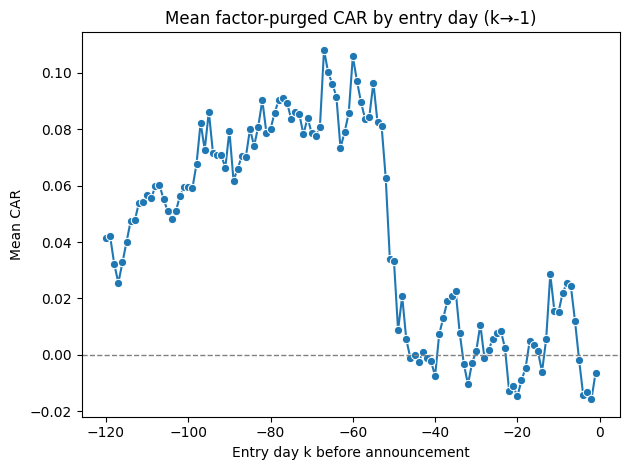

In [233]:

if best_row is not None:
    print(f"Best entry k = {int(best_row['k_entry'])}, mean CAR = {best_row['mean_CAR']:.4f}, n = {int(best_row['n_events'])}, t = {best_row['tstat'] if not np.isnan(best_row['tstat']) else float('nan')}")
else:
    print("No CAR results (insufficient data).")

sns.lineplot(data=car_df, x='k_entry', y='mean_CAR', marker='o')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Mean factor-purged CAR by entry day (k→-1)')
plt.xlabel('Entry day k before announcement')
plt.ylabel('Mean CAR')
plt.tight_layout()
plt.show()


,k_entry,mean_CAR,n_events,tstat
0,-120,0.041424,15,0.310562
1,-119,0.042025,15,0.316789
2,-118,0.032261,15,0.237489
3,-117,0.025564,15,0.190309
4,-116,0.032761,15,0.242955
...,...,...,...,...
115,-5,-0.001706,15,-0.121747
116,-4,-0.014164,15,-1.074100
117,-3,-0.013312,15,-1.163511
118,-2,-0.015726,15,-2.766797


Best entry k = -67 (mean CAR = 0.1082, n = 15, t = 1.28 if available)


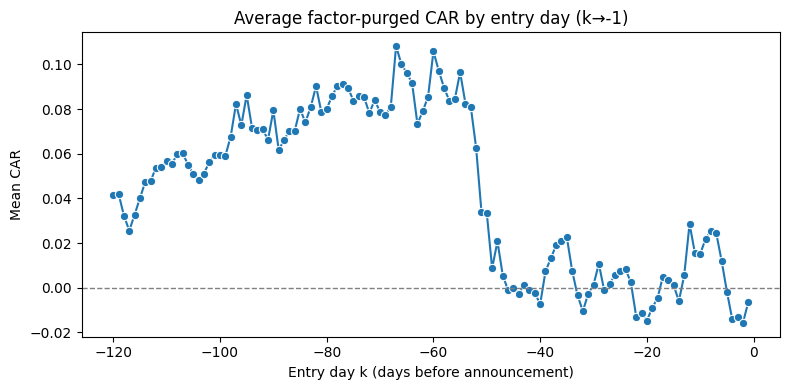

In [234]:

# Summarize and plot CAR by entry day

display(car_df)
if best_row is not None:
    print(f"Best entry k = {int(best_row['k_entry'])} (mean CAR = {best_row['mean_CAR']:.4f}, n = {int(best_row['n_events'])}, t = {best_row['tstat']:.2f} if available)")
else:
    print("No CAR results computed (insufficient data).")

plt.figure(figsize=(8, 4))
sns.lineplot(data=car_df, x='k_entry', y='mean_CAR', marker='o')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Average factor-purged CAR by entry day (k→-1)')
plt.xlabel('Entry day k (days before announcement)')
plt.ylabel('Mean CAR')
plt.tight_layout()
plt.show()
